# Importing Libraries:

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm
from datetime import datetime
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import VarianceThreshold
import math
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
import re
from scipy.sparse import hstack
import lightgbm as ltb
import pickle
from sklearn.metrics import mean_squared_error
import math
from sklearn.model_selection import RandomizedSearchCV
import shap

In [2]:
data = pd.read_csv("uk_accident_dataset.csv")

In [3]:
data.shape

(478741, 27)

In [4]:
data.head()

,Accident_ID,Police_Force,Number_of_Vehicles,Number_of_Casualties,Date,Day_of_Week,Time,Local_Authority_(District),Local_Authority_(Highway),1st_Road_Class,...,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Special_Conditions_at_Site,Carriageway_Hazards,Urban_or_Rural_Area,Did_Police_Officer_Attend_Scene_of_Accident,state,postcode,country
0,1,34,2,1,19/12/12,7,13:20,344,E10000032,4,...,Daylight: Street light present,Fine without high winds,Dry,Ol or diesel,None,1,Yes,England,OX3 9UP,United Kingdom
1,2,5,2,1,02/11/12,4,7:53,102,E09000026,3,...,Daylight: Street light present,Raining without high winds,Dry,None,None,1,No,England,S35 4EZ,United Kingdom
2,3,1,2,1,02/11/12,4,16:00,531,E10000016,6,...,Daylight: Street light present,Fine without high winds,Dry,None,None,1,No,England,BN21 2XR,United Kingdom
3,4,1,1,1,06/05/12,1,16:50,7,E08000035,6,...,Daylight: Street light present,Fine without high winds,Dry,Roadworks,None,1,Yes,England,TA20 3PT,United Kingdom
4,5,46,1,1,30/06/12,3,13:25,519,E10000031,3,...,Daylight: Street light present,Fine without high winds,Dry,None,None,1,No,England,DN20 0QF,United Kingdom


# Data Summary:

In [5]:
data.info() # general summary of data.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 478741 entries, 0 to 478740
Data columns (total 27 columns):
 #   Column                                       Non-Null Count   Dtype 
---  ------                                       --------------   ----- 
 0   Accident_ID                                  478741 non-null  int64 
 1   Police_Force                                 478741 non-null  int64 
 2   Number_of_Vehicles                           478741 non-null  int64 
 3   Number_of_Casualties                         478741 non-null  int64 
 4   Date                                         478741 non-null  object
 5   Day_of_Week                                  478741 non-null  int64 
 6   Time                                         478727 non-null  object
 7   Local_Authority_(District)                   478741 non-null  int64 
 8   Local_Authority_(Highway)                    478741 non-null  object
 9   1st_Road_Class                               478741 non-null  int64 
 

In [6]:
data.isnull().sum() # we see the number of null values for each feature.

Accident_ID                                      0
Police_Force                                     0
Number_of_Vehicles                               0
Number_of_Casualties                             0
Date                                             0
Day_of_Week                                      0
Time                                            14
Local_Authority_(District)                       0
Local_Authority_(Highway)                        0
1st_Road_Class                                   0
1st_Road_Number                                  0
Road_Type                                        0
Speed_limit                                      0
2nd_Road_Class                                   0
2nd_Road_Number                                  0
Pedestrian_Crossing-Human_Control                0
Pedestrian_Crossing-Physical_Facilities          0
Light_Conditions                                 0
Weather_Conditions                               0
Road_Surface_Conditions        

- Null values are present for **Time, Road_Surface_Conditions and Special_Conditions_at_Site**.
- Let's handle these first.

# Handling Missing Values:

# Road_Surface_Conditions

In [7]:
data['Road_Surface_Conditions'].value_counts() # here we get an idea of most occuring categorical variable

Dry                          365843
Wet/Damp                      87570
Frost/Ice                     16172
Snow                           8613
Flood (Over 3cm of water)        91
Name: Road_Surface_Conditions, dtype: int64

In [8]:
print("Null values before filling :",data['Road_Surface_Conditions'].isnull().sum())

Null values before filling : 452


In [9]:
data['Road_Surface_Conditions'].fillna("Dry", inplace = True) # filling the null values with most occuring variable

In [10]:
print("Null values after filling :",data['Road_Surface_Conditions'].isnull().sum())

Null values after filling : 0


# Special_Conditions_at_Site

In [11]:
scs = data["Special_Conditions_at_Site"].value_counts()
scs

None                                               427839
Roadworks                                           45252
Ol or diesel                                         1371
Road surface defective                               1289
Mud                                                  1104
Auto traffic singal out                               885
Permanent sign or marking defective or obscured       660
Auto traffic signal partly defective                  278
Name: Special_Conditions_at_Site, dtype: int64

In [12]:
print("Null values before filling :",data["Special_Conditions_at_Site"].isnull().sum())

Null values before filling : 63


In [13]:
print("None category covers {}% here.".format(round(100*(scs)[0]/data.shape[0],2)))

None category covers 89.37% here.


- Converting this "None" to "Normal". 
- As, None special condition could mean that the condition at site is normal.
- Hence, we won't drop these column but actually use the "Normal" instead of "None" and fill the missing values with "Normal".


In [14]:
# filling the missing values with "None"
data['Special_Conditions_at_Site'].fillna("None", inplace = True)

In [15]:
print("Null values after filling :",data["Special_Conditions_at_Site"].isnull().sum())

Null values after filling : 0


In [16]:
# Replacing the "None" category with "Normal" for better interpretation
data["Special_Conditions_at_Site"].replace(to_replace ="None", value ="Normal", inplace = True)

In [17]:
scs_new = data["Special_Conditions_at_Site"].value_counts()
scs_new

Normal                                             427902
Roadworks                                           45252
Ol or diesel                                         1371
Road surface defective                               1289
Mud                                                  1104
Auto traffic singal out                               885
Permanent sign or marking defective or obscured       660
Auto traffic signal partly defective                  278
Name: Special_Conditions_at_Site, dtype: int64

# Country:

In [18]:
data["country"].value_counts()

United Kingdom    478741
Name: country, dtype: int64

- We will drop this column as there is 0 variance.


# Features related to Time:

# Date

In [19]:
data["Date"].info()

<class 'pandas.core.series.Series'>
RangeIndex: 478741 entries, 0 to 478740
Series name: Date
Non-Null Count   Dtype 
--------------   ----- 
478741 non-null  object
dtypes: object(1)
memory usage: 3.7+ MB


- The date here is a string, we have to convert it into datetime object.
- Extract **Day and Month** from above.

In [20]:
data['Date'] = data['Date'].astype('datetime64[ns]') # converting to date time object

In [21]:
data['Date'].info() # we can see that the object type has changed now.

<class 'pandas.core.series.Series'>
RangeIndex: 478741 entries, 0 to 478740
Series name: Date
Non-Null Count   Dtype         
--------------   -----         
478741 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 3.7 MB


In [22]:
data["Month"] = pd.DatetimeIndex(data["Date"]).month # extract month from date

In [23]:
data["Day"] = pd.DatetimeIndex(data["Date"]).day # extract day from date

In [24]:
data[["Date","Month","Day"]].head(10) # we see the extracted new columns below

,Date,Month,Day
0,2012-12-19,12,19
1,2012-02-11,2,11
2,2012-02-11,2,11
3,2012-06-05,6,5
4,2012-06-30,6,30
5,2012-04-03,4,3
6,2012-11-04,11,4
7,2012-06-06,6,6
8,2012-03-27,3,27
9,2012-09-13,9,13


In [25]:
data['Time'].isnull().sum() # checking the null values

14

In [26]:
# below we see all the Nan values for Time
null = data[data.isnull().any(1)]
null

,Accident_ID,Police_Force,Number_of_Vehicles,Number_of_Casualties,Date,Day_of_Week,Time,Local_Authority_(District),Local_Authority_(Highway),1st_Road_Class,...,Road_Surface_Conditions,Special_Conditions_at_Site,Carriageway_Hazards,Urban_or_Rural_Area,Did_Police_Officer_Attend_Scene_of_Accident,state,postcode,country,Month,Day
51512,64438,42,2,2,2012-07-28,6,NaN,504,E06000049,4,...,Dry,Normal,None,2,Yes,England,ST17 0NY,United Kingdom,7,28
61523,76925,51,2,1,2012-06-02,5,NaN,716,E06000003,3,...,Wet/Damp,Roadworks,None,1,Yes,Cymru / Wales,LN11 8UJ,United Kingdom,6,2
72250,90446,5,1,1,2012-01-17,6,NaN,94,E06000029,6,...,Dry,Normal,None,1,Yes,England,LE10 2DN,United Kingdom,1,17
151076,189104,21,1,2,2012-04-02,7,NaN,287,E10000028,3,...,Dry,Normal,None,2,Yes,England,WS11 1HE,United Kingdom,4,2
152575,190977,61,2,1,2012-03-11,5,NaN,683,E06000038,6,...,Dry,Normal,None,1,Yes,Cymru / Wales,NR10 4DT,United Kingdom,3,11
160861,201372,1,2,1,2012-04-09,6,NaN,23,E06000014,6,...,Dry,Normal,None,1,Yes,England,PR25 3BF,United Kingdom,4,9
209845,262812,21,2,2,2012-09-04,7,NaN,362,W06000016,6,...,Dry,Normal,None,1,No,England,HG2 7DD,United Kingdom,9,4
223830,280336,21,2,1,2012-11-13,3,NaN,221,E10000029,3,...,Frost/Ice,Normal,None,2,Yes,England,RG45 7HF,United Kingdom,11,13
314698,394275,95,3,1,2012-03-02,5,NaN,941,E06000017,6,...,Dry,Normal,None,1,Yes,Alba / Scotland,NR11 6PJ,United Kingdom,3,2
323568,405453,21,4,1,2012-07-20,3,NaN,137,E06000050,3,...,Frost/Ice,Normal,None,2,Yes,Alba / Scotland,WA6 8LE,United Kingdom,7,20


In [27]:
data.dropna(inplace = True) # dropping all the Nan values

In [28]:
data.shape

(478727, 29)

# Time

- Converting the time to **Morning, Afternoon, Evening, Night**

In [29]:
data['Time'] = data['Time'].astype('datetime64[ns]') # converting to date time object
data['Time'] = pd.to_datetime(data['Time']).dt.time # extract time
data['Time'] = data['Time'].astype(str) # converting to string for comparing the time for the required conversion

In [30]:
# Below we divide the 24 hour format into  4 phases based on simple time comparison

data.loc[(data["Time"] >= '00:00:00') & (data["Time"] < '05:00:00'), 'Time'] = "Night"
data.loc[(data["Time"] >= '05:00:00') & (data["Time"] < '12:00:00'), 'Time'] = "Morning"
data.loc[(data["Time"] >= '12:00:00') & (data["Time"] < '17:00:00'), 'Time'] = "Afternoon"
data.loc[(data["Time"] >= '17:00:00') & (data["Time"] < '21:00:00'), 'Time'] = "Evening"
data.loc[(data["Time"] >= '21:00:00') & (data["Time"] <= '23:59:00'), 'Time'] = "Night"

In [31]:
data[["Date","Time"]].head(10)

,Date,Time
0,2012-12-19,Afternoon
1,2012-02-11,Morning
2,2012-02-11,Afternoon
3,2012-06-05,Afternoon
4,2012-06-30,Afternoon
5,2012-04-03,Afternoon
6,2012-11-04,Afternoon
7,2012-06-06,Night
8,2012-03-27,Afternoon
9,2012-09-13,Evening


In [32]:
data["Time"].isnull().sum() # no null values now for time

0

In [33]:
data.drop(["Date","2nd_Road_Number","country"], axis = 1 , inplace = True) # dropping the features with low variance

In [34]:
data.shape

(478727, 26)

# Data Visualisation:

# Police Force:

<AxesSubplot:xlabel='Police_Force', ylabel='Density'>

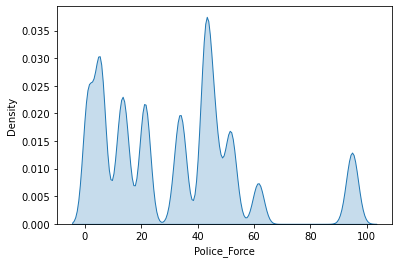

In [35]:
sns.kdeplot(data["Police_Force"], shade =True) # to see the distribution of this continuous variable

<AxesSubplot:>

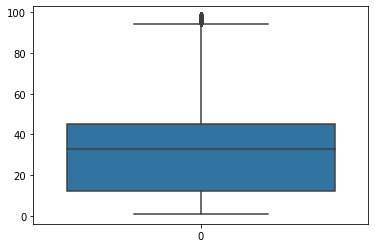

In [36]:
sns.boxplot(data = data["Police_Force"])

- Police_force > 100 are the outliers.

# Number_of_Vehicles:

In [37]:
data["Number_of_Vehicles"].value_counts()

2    281588
1    163059
3     26848
4      7232
Name: Number_of_Vehicles, dtype: int64

<BarContainer object of 4 artists>

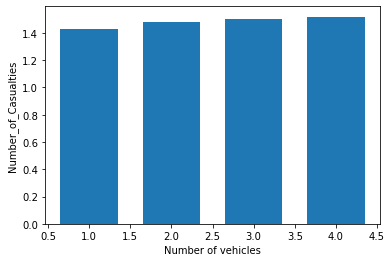

In [38]:
x1 = data.groupby('Number_of_Vehicles').agg({'Number_of_Casualties': 'mean'}).reset_index()
x = list(x1['Number_of_Vehicles'].values) # defining x axis
y = list(x1['Number_of_Casualties'].values) # defining y axis
plt.xlabel("Number of vehicles")
plt.ylabel("Number_of_Casualties")
plt.bar(x,y,width = 0.7)

- As the number of vehicles increases number of casulaities also increases.

<AxesSubplot:>

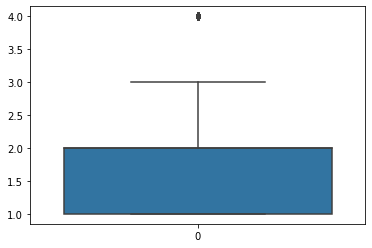

In [39]:
sns.boxplot(data = data["Number_of_Vehicles"])

# Time:

<BarContainer object of 4 artists>

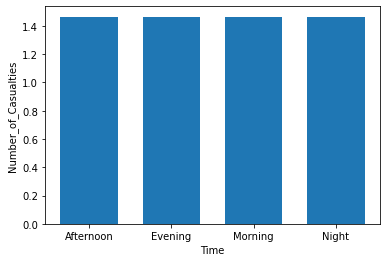

In [40]:
x1 = data.groupby('Time').agg({'Number_of_Casualties': 'mean'}).reset_index()
x = list(x1['Time'].values) # defining x axis
y = list(x1['Number_of_Casualties'].values) # defining y axis
plt.xlabel("Time")
plt.ylabel("Number_of_Casualties")
plt.bar(x,y,width = 0.7)

- Mean number of casualities is same for all 4 phases of the day.

# Weather condition:

<BarContainer object of 9 artists>

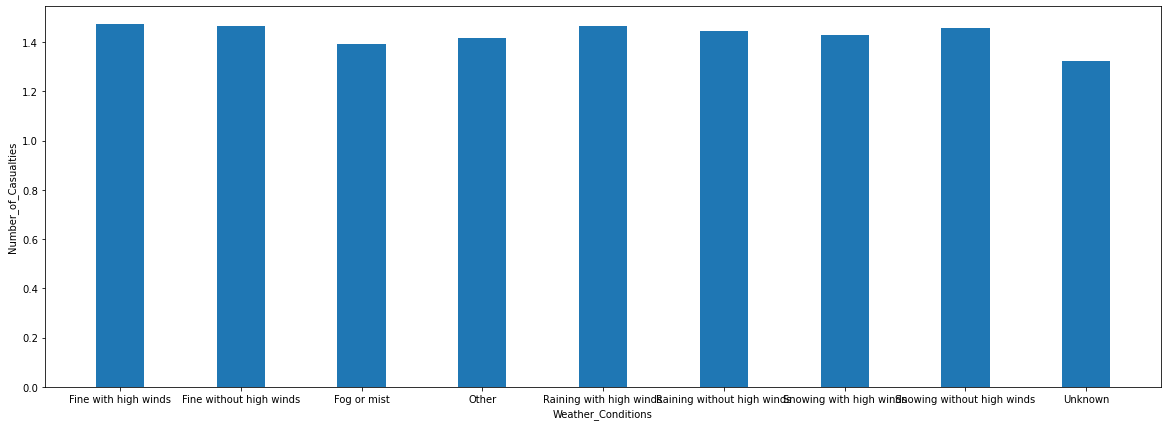

In [41]:
x1 = data.groupby('Weather_Conditions').agg({'Number_of_Casualties': 'mean'}).reset_index()
x = list(x1['Weather_Conditions'].values) # defining x axis
y = list(x1['Number_of_Casualties'].values) # defining y axis
plt.figure(figsize=(20, 7))
plt.xlabel("Weather_Conditions")
plt.ylabel("Number_of_Casualties")
plt.bar(x,y,width = 0.4)

- The above graph shows how casualities vary with different weather conditons.

# Road type:

<BarContainer object of 6 artists>

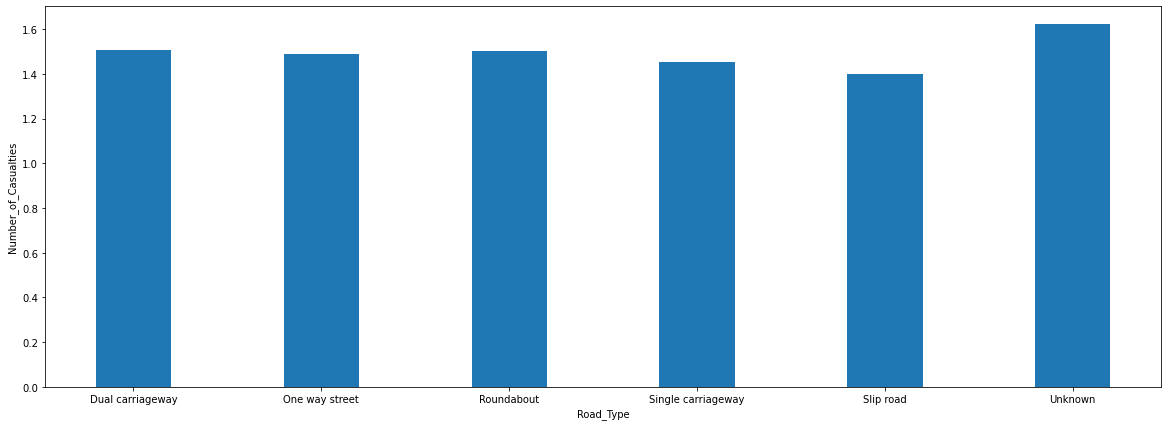

In [42]:
x1 = data.groupby('Road_Type').agg({'Number_of_Casualties': 'mean'}).reset_index()
x = list(x1['Road_Type'].values) # defining x axis
y = list(x1['Number_of_Casualties'].values) # defining y axis
plt.figure(figsize=(20, 7))
plt.xlabel("Road_Type")
plt.ylabel("Number_of_Casualties")
plt.bar(x,y,width = 0.4)

- It's suprising to see that if the road is slippery then the number of casuality is less

# Speed Limit:

<BarContainer object of 6 artists>

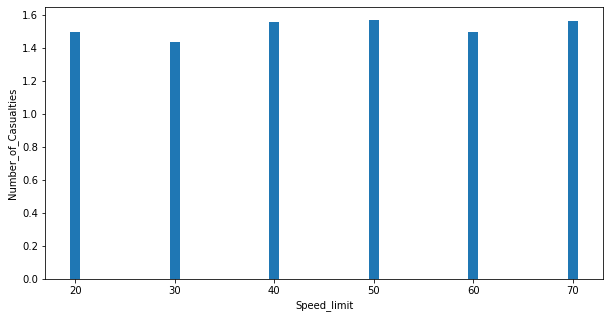

In [43]:
x1 = data.groupby('Speed_limit').agg({'Number_of_Casualties': 'mean'}).reset_index()
x = list(x1['Speed_limit'].values) # defining x axis
y = list(x1['Number_of_Casualties'].values) # defining y axis
plt.figure(figsize=(10, 5))
plt.xlabel("Speed_limit")
plt.ylabel("Number_of_Casualties")
plt.bar(x,y,width = 1)

- For a speed of 50-70, there are higher number of casualities.

# 1st round class:

<BarContainer object of 5 artists>

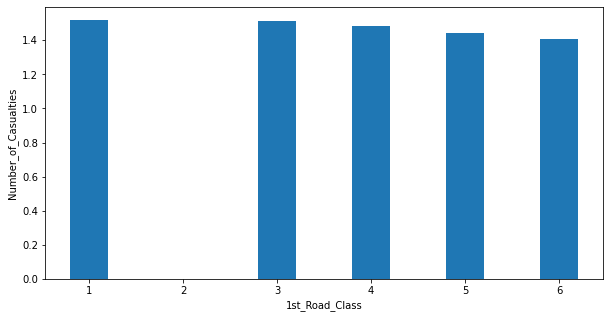

In [44]:
x1 = data.groupby('1st_Road_Class').agg({'Number_of_Casualties': 'mean'}).reset_index()
x = list(x1['1st_Road_Class'].values) # defining x axis
y = list(x1['Number_of_Casualties'].values) # defining y axis
plt.figure(figsize=(10, 5))
plt.xlabel("1st_Road_Class")
plt.ylabel("Number_of_Casualties")
plt.bar(x,y,width = 0.4)

# Pedestrian_Crossing-Human_Control

<BarContainer object of 3 artists>

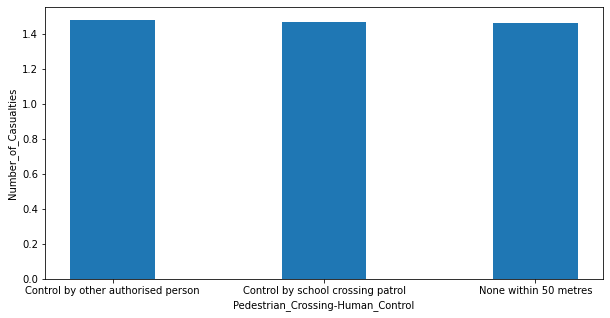

In [45]:
x1 = data.groupby('Pedestrian_Crossing-Human_Control').agg({'Number_of_Casualties': 'mean'}).reset_index()
x = list(x1['Pedestrian_Crossing-Human_Control'].values) # defining x axis
y = list(x1['Number_of_Casualties'].values) # defining y axis
plt.figure(figsize=(10, 5))
plt.xlabel("Pedestrian_Crossing-Human_Control")
plt.ylabel("Number_of_Casualties")
plt.bar(x,y,width = 0.4)

# Urban or Rural:

<BarContainer object of 2 artists>

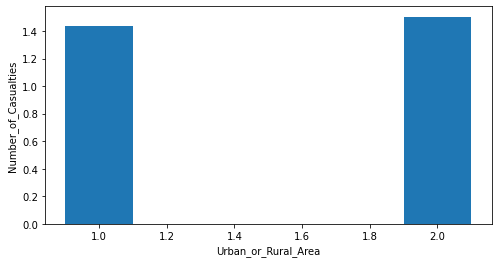

In [47]:
x1 = data.groupby('Urban_or_Rural_Area').agg({'Number_of_Casualties': 'mean'}).reset_index()
x = list(x1['Urban_or_Rural_Area'].values) # defining x axis
y = list(x1['Number_of_Casualties'].values) # defining y axis
plt.figure(figsize=(8, 4))
plt.xlabel("Urban_or_Rural_Area")
plt.ylabel("Number_of_Casualties")
plt.bar(x,y,width = 0.2)

# State:

<BarContainer object of 3 artists>

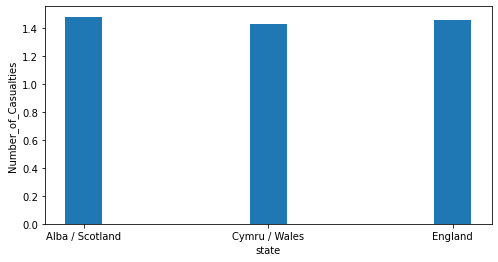

In [48]:
x1 = data.groupby('state').agg({'Number_of_Casualties': 'mean'}).reset_index()
x = list(x1['state'].values) # defining x axis
y = list(x1['Number_of_Casualties'].values) # defining y axis
plt.figure(figsize=(8, 4))
plt.xlabel("state")
plt.ylabel("Number_of_Casualties")
plt.bar(x,y,width = 0.2)

- Mean casualities is same for all 3 states.

# Drop low variance features:

In [49]:
# selecting the categorical features to be dropped.
data_new = data[['Time','Local_Authority_(Highway)','Road_Type','Pedestrian_Crossing-Human_Control',
               'Pedestrian_Crossing-Physical_Facilities', 'Light_Conditions','Weather_Conditions', 'Road_Surface_Conditions',
               'Special_Conditions_at_Site', 'Carriageway_Hazards','Did_Police_Officer_Attend_Scene_of_Accident',
               'state', 'postcode']]

In [50]:
data_new.head(2)

,Time,Local_Authority_(Highway),Road_Type,Pedestrian_Crossing-Human_Control,Pedestrian_Crossing-Physical_Facilities,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Special_Conditions_at_Site,Carriageway_Hazards,Did_Police_Officer_Attend_Scene_of_Accident,state,postcode
0,Afternoon,E10000032,Single carriageway,None within 50 metres,No physical crossing within 50 meters,Daylight: Street light present,Fine without high winds,Dry,Ol or diesel,None,Yes,England,OX3 9UP
1,Morning,E09000026,One way street,None within 50 metres,No physical crossing within 50 meters,Daylight: Street light present,Raining without high winds,Dry,Normal,None,No,England,S35 4EZ


In [51]:
# label encoding the categorical features.
ord_enc = OrdinalEncoder()
data_new[['Time','Local_Authority_(Highway)','Road_Type','Pedestrian_Crossing-Human_Control','Pedestrian_Crossing-Physical_Facilities', 'Light_Conditions','Weather_Conditions', 'Road_Surface_Conditions','Special_Conditions_at_Site', 'Carriageway_Hazards','Did_Police_Officer_Attend_Scene_of_Accident',
        'state', 'postcode']] = ord_enc.fit_transform(data_new[['Time','Local_Authority_(Highway)','Road_Type','Pedestrian_Crossing-Human_Control','Pedestrian_Crossing-Physical_Facilities', 'Light_Conditions','Weather_Conditions', 'Road_Surface_Conditions','Special_Conditions_at_Site', 'Carriageway_Hazards','Did_Police_Officer_Attend_Scene_of_Accident','state', 'postcode']])


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [52]:
data_new.head(5)

,Time,Local_Authority_(Highway),Road_Type,Pedestrian_Crossing-Human_Control,Pedestrian_Crossing-Physical_Facilities,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Special_Conditions_at_Site,Carriageway_Hazards,Did_Police_Officer_Attend_Scene_of_Accident,state,postcode
0,0.0,150.0,3.0,2.0,2.0,4.0,1.0,0.0,4.0,3.0,1.0,2.0,60630.0
1,2.0,117.0,1.0,2.0,2.0,4.0,5.0,0.0,3.0,3.0,0.0,2.0,69641.0
2,0.0,136.0,2.0,2.0,4.0,4.0,1.0,0.0,3.0,3.0,0.0,2.0,7678.0
3,0.0,90.0,3.0,2.0,2.0,4.0,1.0,0.0,7.0,3.0,1.0,2.0,83198.0
4,0.0,149.0,0.0,2.0,4.0,4.0,1.0,0.0,3.0,3.0,0.0,2.0,22448.0


In [53]:
# Removing all those features which are 75% similar. (Those which are having low variance)
var_thr = VarianceThreshold(threshold = 0.25) #Removing both constant and quasi-constant
var_thr.fit(data_new)

VarianceThreshold(threshold=0.25)

In [54]:
# The below code returns a list of features to be dropped.
concol = [column for column in data_new.columns 
          if column not in data_new.columns[var_thr.get_support()]]

for features in concol:
    print(features)

Pedestrian_Crossing-Human_Control
Carriageway_Hazards
Did_Police_Officer_Attend_Scene_of_Accident


- The above features are to be dropped.

In [55]:
data.drop(concol,axis=1,inplace = True) # dropping the features with very low features.

In [56]:
data

,Accident_ID,Police_Force,Number_of_Vehicles,Number_of_Casualties,Day_of_Week,Time,Local_Authority_(District),Local_Authority_(Highway),1st_Road_Class,1st_Road_Number,...,Pedestrian_Crossing-Physical_Facilities,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Special_Conditions_at_Site,Urban_or_Rural_Area,state,postcode,Month,Day
0,1,34,2,1,7,Afternoon,344,E10000032,4,395,...,No physical crossing within 50 meters,Daylight: Street light present,Fine without high winds,Dry,Ol or diesel,1,England,OX3 9UP,12,19
1,2,5,2,1,4,Morning,102,E09000026,3,13,...,No physical crossing within 50 meters,Daylight: Street light present,Raining without high winds,Dry,Normal,1,England,S35 4EZ,2,11
2,3,1,2,1,4,Afternoon,531,E10000016,6,8,...,Zebra crossing,Daylight: Street light present,Fine without high winds,Dry,Normal,1,England,BN21 2XR,2,11
3,4,1,1,1,1,Afternoon,7,E08000035,6,13,...,No physical crossing within 50 meters,Daylight: Street light present,Fine without high winds,Dry,Roadworks,1,England,TA20 3PT,6,5
4,5,46,1,1,3,Afternoon,519,E10000031,3,24,...,Zebra crossing,Daylight: Street light present,Fine without high winds,Dry,Normal,1,England,DN20 0QF,6,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
478736,599995,13,1,1,6,Afternoon,199,E10000015,6,0,...,No physical crossing within 50 meters,Daylight: Street light present,Fine without high winds,Snow,Normal,2,England,E12 6EA,9,28
478737,599996,13,2,1,4,Evening,211,E09000012,6,1293,...,No physical crossing within 50 meters,Daylight: Street light present,Fine without high winds,Wet/Damp,Normal,1,England,NN2 8PF,1,23
478738,599997,6,2,4,6,Morning,80,E06000047,3,310,...,No physical crossing within 50 meters,Daylight: Street light present,Fine without high winds,Dry,Normal,1,England,DN36 5FR,5,15
478739,599998,33,2,1,2,Morning,321,E10000024,3,3283,...,No physical crossing within 50 meters,Daylight: Street light present,Fine without high winds,Dry,Normal,2,England,BN11 2EB,9,10


In [57]:
data.drop(["Day"],axis=1,inplace = True) # dropping the "day" feature as it won't add much power to our model.

In [58]:
data.shape

(478727, 22)

In [59]:
data.to_csv("good_variance.csv") # saving the file

In [60]:
data = pd.read_csv("good_variance.csv")

# Data Cleaning: Categorical Features

- We clean the categorical features as they would be One hot encoded later.

In [61]:
categorical = ["Road_Type","Pedestrian_Crossing-Physical_Facilities",
               "Light_Conditions","Weather_Conditions","Road_Surface_Conditions","Special_Conditions_at_Site",
              "state"]

In [62]:
data[categorical].head(2)

,Road_Type,Pedestrian_Crossing-Physical_Facilities,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Special_Conditions_at_Site,state
0,Single carriageway,No physical crossing within 50 meters,Daylight: Street light present,Fine without high winds,Dry,Ol or diesel,England
1,One way street,No physical crossing within 50 meters,Daylight: Street light present,Raining without high winds,Dry,Normal,England


The following cleaning has been done:
- Replacing empty strings with "_"
- Lowering the characters
- removing unnecessary characters

# Road type:

In [63]:
data["Road_Type"].value_counts()

Single carriageway    372545
Dual carriageway       52780
Roundabout             28540
One way street         24310
Slip road                523
Unknown                   29
Name: Road_Type, dtype: int64

In [64]:
road = []
for i in list(data['Road_Type'].values):
    txt = i.lower() # converting to lowercase
    txt = re.sub(" ",'_', txt)
    road.append(txt)

In [65]:
data["Road_Type"] = road

In [66]:
data["Road_Type"].value_counts()

single_carriageway    372545
dual_carriageway       52780
roundabout             28540
one_way_street         24310
slip_road                523
unknown                   29
Name: Road_Type, dtype: int64

# Pedestrian_Crossing-Physical_Facilities

In [67]:
data["Pedestrian_Crossing-Physical_Facilities"].value_counts()

No physical crossing within 50 meters          404552
Pedestrian phase at traffic signal junction     35616
Zebra crossing                                  27005
non-junction pedestrian crossing                 9659
Central refuge                                   1833
Footbridge or subway                               62
Name: Pedestrian_Crossing-Physical_Facilities, dtype: int64

In [68]:
pedestrian = []
for i in list(data['Pedestrian_Crossing-Physical_Facilities'].values):
    txt = i.lower() # converting to lowercase
    txt = re.sub("-",'_', txt)
    txt = re.sub(" ",'_', txt)
    pedestrian.append(txt)

In [69]:
data["Pedestrian_Crossing-Physical_Facilities"] = pedestrian

In [70]:
data["Pedestrian_Crossing-Physical_Facilities"].value_counts()

no_physical_crossing_within_50_meters          404552
pedestrian_phase_at_traffic_signal_junction     35616
zebra_crossing                                  27005
non_junction_pedestrian_crossing                 9659
central_refuge                                   1833
footbridge_or_subway                               62
Name: Pedestrian_Crossing-Physical_Facilities, dtype: int64

# Light_Conditions:

In [71]:
light = []
for i in list(data['Light_Conditions'].values):
    txt = i.lower() # converting to lowercase
    txt = re.sub(":",'', txt)
    txt = re.sub(" ",'_', txt)
    light.append(txt)

In [72]:
data["Light_Conditions"] = light

# Weather_Conditions:

In [73]:
weather = []
for i in list(data['Weather_Conditions'].values):
    txt = i.lower() # converting to lowercase
    txt = re.sub(" ",'_', txt)
    weather.append(txt)

In [74]:
data['Weather_Conditions'] = weather

# Road_Surface_Conditions:

In [75]:
road_surface = []
for i in list(data['Road_Surface_Conditions'].values):
    if i == 'Flood (Over 3cm of water)':
        road_surface.append("flood")
    else:
        txt = i.lower() # converting to lowercase
        txt = re.sub("/",'_', txt)
        txt = re.sub(" ",'_', txt)
        txt = re.sub("()","",txt)
        road_surface.append(txt)

In [76]:
data["Road_Surface_Conditions"] = road_surface

# State:

In [78]:
state = []
for i in list(data['state'].values):
    txt = i.lower() # converting to lowercase
    txt = re.sub("/",' ', txt)
    txt = re.sub(" ",'', txt)
    state.append(txt)

In [79]:
data["state"] = state

In [ ]:
#data.to_csv("clean_data.csv")

# Preprocessing:

In [2]:
data = pd.read_csv("clean_data.csv")

In [3]:
#categorical = ["1st_Road_Class","Road_Type","2nd_Road_Class","Pedestrian_Crossing-Physical_Facilities",
              # "Light_Conditions","Weather_Conditions","Road_Surface_Conditions","Special_Conditions_at_Site",
             # "Urban_or_Rural_Area","state"]+
        

#numerical = ["Police_Force","Number_of_Vehicles","Number_of_Casualties","Speed_limit"]

#cyclical = ["Day_of_Week","Month","Time"]

#label = ["Local_Authority_(District)","Local_Authority_(Highway)","1st_Road_Number","postcode"]

In [3]:
data.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'Accident_ID', 'Police_Force',
       'Number_of_Vehicles', 'Number_of_Casualties', 'Day_of_Week', 'Time',
       'Local_Authority_(District)', 'Local_Authority_(Highway)',
       '1st_Road_Class', '1st_Road_Number', 'Road_Type', 'Speed_limit',
       '2nd_Road_Class', 'Pedestrian_Crossing-Physical_Facilities',
       'Light_Conditions', 'Weather_Conditions', 'Road_Surface_Conditions',
       'Special_Conditions_at_Site', 'Urban_or_Rural_Area', 'state',
       'postcode', 'Month'],
      dtype='object')

In [4]:
data.head(4)

,Unnamed: 0.1,Unnamed: 0,Accident_ID,Police_Force,Number_of_Vehicles,Number_of_Casualties,Day_of_Week,Time,Local_Authority_(District),Local_Authority_(Highway),...,2nd_Road_Class,Pedestrian_Crossing-Physical_Facilities,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Special_Conditions_at_Site,Urban_or_Rural_Area,state,postcode,Month
0,0,0,1,34,2,1,7,Afternoon,344,E10000032,...,-1,no_physical_crossing_within_50_meters,daylight_street_light_present,fine_without_high_winds,dry,ol_or_diesel,1,england,OX3 9UP,12
1,1,1,2,5,2,1,4,Morning,102,E09000026,...,-1,no_physical_crossing_within_50_meters,daylight_street_light_present,raining_without_high_winds,dry,normal,1,england,S35 4EZ,2
2,2,2,3,1,2,1,4,Afternoon,531,E10000016,...,6,zebra_crossing,daylight_street_light_present,fine_without_high_winds,dry,normal,1,england,BN21 2XR,2
3,3,3,4,1,1,1,1,Afternoon,7,E08000035,...,6,no_physical_crossing_within_50_meters,daylight_street_light_present,fine_without_high_winds,dry,roadworks,1,england,TA20 3PT,6


In [5]:
x = data.drop(["Unnamed: 0.1","Unnamed: 0","Number_of_Casualties"], axis=1) 
y = data["Number_of_Casualties"] # Treating casualities as target variable for now.

In [6]:
# Doing stratified splitting:
strat_shuffle = StratifiedShuffleSplit(test_size = 0.25, random_state = 0)

train_index, test_index = next(strat_shuffle.split(x,y))

In [7]:
train_index

array([409840, 283848, 368007, ...,  40690, 332406, 336456], dtype=int64)

In [8]:
x_train = data.loc[train_index,x.columns]
y_train = data.loc[train_index,"Number_of_Casualties"]

x_test = data.loc[test_index,x.columns]
y_test = data.loc[test_index,"Number_of_Casualties"]

print("Train data :",x_train.shape)
print("Test data :",x_test.shape)

Train data : (359045, 21)
Test data : (119682, 21)


# Setting up Target Variable:

In [9]:
# Concat features and targets to form new target variable
xy_train = pd.concat([x_train,y_train], axis = 1)
xy_test = pd.concat([x_test,y_test], axis = 1)

In [10]:
def acc_risk_idx(data):
    """
    This function calculates the accident risk index 
    
    """
    
    group_postcode = data.groupby(by = 'postcode') # grouping by postcode
    
    # for each postcode, the following returns the accident risk index
    acc_risk_index = group_postcode['Number_of_Casualties'].sum()/group_postcode['Accident_ID'].count()
    acc_risk_index = dict(acc_risk_index) # creating a dictionary to access the risk index for given postcode
    result = [acc_risk_index[res] for res in data["postcode"].values] # return a list of risk indexes for 
                                                                      # every postcode in dataframe
    return result

In [11]:
train_acc_risk = acc_risk_idx(xy_train) # storing the calculated risk index for train data
test_acc_risk = acc_risk_idx(xy_test) # storing the calculated risk index for test data

In [12]:
# adding the target variable to train & test set.
xy_train["accident_risk_index"] = train_acc_risk
xy_test["accident_risk_index"] = test_acc_risk

In [13]:
# Creating the final dataframe for modeling.
X_train = xy_train.drop(["Accident_ID","accident_risk_index"], axis = 1)
Y_train = xy_train["accident_risk_index"]

X_test = xy_test.drop(["Accident_ID","accident_risk_index"], axis = 1)
Y_test = xy_test["accident_risk_index"]

In [14]:
# Resetting the indexes
X_train = X_train.reset_index().drop(["index"], axis=1)
Y_train = Y_train.reset_index().drop(["index"], axis=1)
X_test = X_test.reset_index().drop(["index"], axis=1)
Y_test = Y_test.reset_index().drop(["index"], axis=1)

In [15]:
with open('Y_train', 'wb') as fp:
    pickle.dump(Y_train, fp)

In [16]:
with open('Y_test', 'wb') as fp:
    pickle.dump(Y_test, fp)

# Cyclical Encoding:

- Performing the cyclical encoding on **Month and Day of the week**

In [17]:
# Adding the encoded values to train set.
X_train['month_sin'] = np.sin((X_train.Month -1)*(2.*np.pi/12))
X_train['month_cos'] = np.cos((X_train.Month -1)*(2.*np.pi/12))
X_train['weekday_sin'] = np.sin((X_train.Day_of_Week-1)*(2.*np.pi/7))
X_train['weekday_cos'] = np.cos((X_train.Day_of_Week-1)*(2.*np.pi/7))

In [18]:
# Adding the encoded values to test set.
X_test['month_sin'] = np.sin((X_test.Month -1)*(2.*np.pi/12))
X_test['month_cos'] = np.cos((X_test.Month -1)*(2.*np.pi/12))
X_test['weekday_sin'] = np.sin((X_test.Day_of_Week-1)*(2.*np.pi/7))
X_test['weekday_cos'] = np.cos((X_test.Day_of_Week-1)*(2.*np.pi/7))

In [19]:
# Dropping the original features once they are encoded
X_train.drop(["Month","Day_of_Week"], axis = 1, inplace = True)
X_test.drop(["Month","Day_of_Week"], axis = 1, inplace = True)

# Normalization:

- Scaling down the numerical features..

In [20]:
numerical = ["Police_Force","Number_of_Vehicles","Number_of_Casualties","Speed_limit"]
scaled = MinMaxScaler()
X_train[numerical] = scaled.fit_transform(X_train[numerical])
X_test[numerical] = scaled.transform(X_test[numerical])

In [21]:
X_train[numerical].head(3)

,Police_Force,Number_of_Vehicles,Number_of_Casualties,Speed_limit
0,0.350515,0.000000,0.0,0.2
1,0.061856,0.333333,0.0,0.2
2,0.422680,0.333333,0.0,0.2


# CatBoost Encoder:

In [22]:
import category_encoders as ce

In [23]:
cbe_encoder = ce.cat_boost.CatBoostEncoder()

In [24]:
label = ["Local_Authority_(District)","Local_Authority_(Highway)","1st_Road_Number","postcode"]

In [25]:
X_train[label] = cbe_encoder.fit_transform(X_train[label],Y_train)
X_test[label] = cbe_encoder.transform(X_test[label],Y_test)

In [26]:
X_train[label].head(3)

,Local_Authority_(District),Local_Authority_(Highway),1st_Road_Number,postcode
0,320,1.463527,409,1.463527
1,95,1.463527,5244,1.463527
2,9,1.463527,17,1.463527


# One Hot Encoding:

In [27]:
def one_hot_encoding(feature,X_train,X_test):
    """
    Given a feature this function returns one hot encoded values
    
    """
    ONE = OneHotEncoder(sparse = False, handle_unknown = 'ignore')
    train = ONE.fit_transform(X_train[(feature)].values.reshape(-1,1))
    test = ONE.transform(X_test[(feature)].values.reshape(-1,1))
    return train,test

In [28]:
categorical = ["1st_Road_Class","Road_Type","2nd_Road_Class","Pedestrian_Crossing-Physical_Facilities",
               "Light_Conditions","Weather_Conditions","Road_Surface_Conditions","Special_Conditions_at_Site",
              "Urban_or_Rural_Area","state","Time"]

- The following lines of codes, performs the One hot encoding for above categorical features.

# "1st_Road_Class"

In [29]:
road_1_train, road_1_test = one_hot_encoding("1st_Road_Class",X_train,X_test)
X_train.drop(["1st_Road_Class"],axis = 1, inplace = True)
X_test.drop(["1st_Road_Class"],axis = 1, inplace = True)

# "Road_Type"

In [30]:
roadtype_train, roadtype_test = one_hot_encoding("Road_Type",X_train,X_test)
X_train.drop(["Road_Type"],axis = 1, inplace = True)
X_test.drop(["Road_Type"],axis = 1, inplace = True)

# "2nd_Road_Class"

In [31]:
road_2_train, road_2_test = one_hot_encoding("2nd_Road_Class",X_train,X_test)
X_train.drop(["2nd_Road_Class"],axis = 1, inplace = True)
X_test.drop(["2nd_Road_Class"],axis = 1, inplace = True)

# "Pedestrian_Crossing-Physical_Facilities"

In [32]:
pedestrian_train, pedestrian_test = one_hot_encoding("Pedestrian_Crossing-Physical_Facilities",X_train,X_test)
X_train.drop(["Pedestrian_Crossing-Physical_Facilities"],axis = 1, inplace = True)
X_test.drop(["Pedestrian_Crossing-Physical_Facilities"],axis = 1, inplace = True)

# "Light_Conditions"

In [33]:
lc_train, lc_test = one_hot_encoding("Light_Conditions",X_train,X_test)
X_train.drop(["Light_Conditions"],axis = 1, inplace = True)
X_test.drop(["Light_Conditions"],axis = 1, inplace = True)

# "Weather_Conditions"

In [34]:
wc_train, wc_test = one_hot_encoding("Weather_Conditions",X_train,X_test)
X_train.drop(["Weather_Conditions"],axis = 1, inplace = True)
X_test.drop(["Weather_Conditions"],axis = 1, inplace = True)

# "Road_Surface_Conditions"

In [35]:
rsc_train, rsc_test = one_hot_encoding("Road_Surface_Conditions",X_train,X_test)
X_train.drop(["Road_Surface_Conditions"],axis = 1, inplace = True)
X_test.drop(["Road_Surface_Conditions"],axis = 1, inplace = True)

# "Special_Conditions_at_Site"

In [36]:
scs_train, scs_test = one_hot_encoding("Special_Conditions_at_Site",X_train,X_test)
X_train.drop(["Special_Conditions_at_Site"],axis = 1, inplace = True)
X_test.drop(["Special_Conditions_at_Site"],axis = 1, inplace = True)

# "Urban_or_Rural_Area"

In [37]:
urban_train, urban_test = one_hot_encoding("Urban_or_Rural_Area",X_train,X_test)
X_train.drop(["Urban_or_Rural_Area"],axis = 1, inplace = True)
X_test.drop(["Urban_or_Rural_Area"],axis = 1, inplace = True)

# "state"

In [38]:
state_train, state_test = one_hot_encoding("state",X_train,X_test)
X_train.drop(["state"],axis = 1, inplace = True)
X_test.drop(["state"],axis = 1, inplace = True)

# "Time"

In [39]:
time_train, time_test = one_hot_encoding("Time",X_train,X_test)
X_train.drop(["Time"],axis = 1, inplace = True)
X_test.drop(["Time"],axis = 1, inplace = True)

# Concatenating categorical features:

In [40]:
cat_train = np.hstack((road_1_train,roadtype_train,road_2_train,pedestrian_train,lc_train,wc_train,rsc_train,scs_train,urban_train,state_train,time_train))
cat_test = np.hstack((road_1_test,roadtype_test,road_2_test,pedestrian_test,lc_test,wc_test,rsc_test,scs_test,urban_test,state_test,time_test))

In [41]:
cat_train_data = pd.DataFrame(cat_train)
cat_test_data = pd.DataFrame(cat_test)

In [42]:
X_train.shape

(359045, 12)

In [43]:
cat_train_data.shape

(359045, 58)

In [44]:
X_train_final = np.hstack((X_train,cat_train_data))
X_test_final = np.hstack((X_test,cat_test_data))

In [43]:
type(X_train_final)

numpy.ndarray

# Saving Dataframes & Models:

In [49]:
with open('X_train', 'wb') as fp:
    pickle.dump(X_train_final, fp)

In [50]:
with open('X_test', 'wb') as fp:
    pickle.dump(X_test_final, fp)

In [51]:
X_train = pickle.load(open('X_train','rb'))

In [52]:
X_test = pickle.load(open('X_test','rb'))

In [126]:
Y_train = pickle.load(open('Y_train','rb'))

In [127]:
Y_test = pickle.load(open('Y_test','rb'))

In [30]:
X_train.shape, X_test.shape

((359045, 23), (119682, 23))

In [45]:
Y_train = Y_train.values
Y_train.shape

(359045, 1)

In [46]:
Y_test = Y_test.values
Y_test.shape

(119682, 1)

In [47]:
X_train = X_train_final
X_test = X_test_final

In [54]:
with open('X_train', 'wb') as fp:
    pickle.dump(X_train, fp)
    
with open('X_test', 'wb') as fp:
    pickle.dump(X_test, fp)
    
with open('Y_train', 'wb') as fp:
    pickle.dump(Y_train, fp)
    
with open('Y_test', 'wb') as fp:
    pickle.dump(Y_test, fp)

# LGBM:

# Without hyperparametre tuning:

In [76]:
model = ltb.LGBMRegressor()
model.fit(X_train,Y_train)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


LGBMRegressor()

In [77]:
predict = model.predict(X_test)

In [78]:
mse = mean_squared_error(Y_test,predict)
print(math.sqrt(mse))

0.3213219476975218


# With hyperparametre tuning:

In [79]:
n_estimators  = [10,30,50,70,100,150]
depth = [2,4,6,8,10]
learning_rate = [0.01,0.05,0.1,0.3]
lambda_l1 = [0,5,15,25,50,70,100]
lambda_l2 = [0,5,15,25,50,70,100]
num_leaves = [16,24,32,40,50,64,128,256]
min_gain_to_split = [0,3,5,8,12,15]
min_data_in_leaf = [200,600,1000,2000,4000,5000]



parameters = {'n_estimators':n_estimators,'max_depth':depth,'num_leaves ':num_leaves, 'min_gain_to_split' : min_gain_to_split,
             'learning_rate':learning_rate,'lambda_l1':lambda_l1, 'lambda_l2':lambda_l2, 'min_data_in_leaf' :min_data_in_leaf}

model = ltb.LGBMRegressor()
random_search = RandomizedSearchCV(estimator = model, param_distributions = parameters, cv = 10, n_jobs = -1,
                                   scoring = 'neg_mean_squared_log_error', verbose = 2, random_state = 0)
random_search.fit(X_train, Y_train)

random_search.best_params_

Fitting 10 folds for each of 10 candidates, totalling 100 fits


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Warning] num_leaves is set=31, num_leaves= will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] Unknown parameter: 40
[LightGBM] [Warning] min_data_in_leaf is set=2000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2000
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100


{'num_leaves ': 40,
 'n_estimators': 100,
 'min_gain_to_split': 0,
 'min_data_in_leaf': 2000,
 'max_depth': 6,
 'learning_rate': 0.3,
 'lambda_l2': 100,
 'lambda_l1': 25}

In [80]:
model_tuned = ltb.LGBMRegressor(n_estimators= 100,min_gain_to_split =0,max_depth = 6,min_data_in_leaf =2000,
                                learning_rate =  0.3,lambda_l2 = 100,lambda_l1 = 25,num_leaves = 40)

model_tuned.fit(X_train,Y_train)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


LGBMRegressor(lambda_l1=25, lambda_l2=100, learning_rate=0.3, max_depth=6,
              min_data_in_leaf=2000, min_gain_to_split=0, num_leaves=40)

In [81]:
predict_train = model_tuned.predict(X_train)
mse_better_train = mean_squared_error(Y_train,predict_train)
print(math.sqrt(mse_better_train))

0.20369589312432762


In [82]:
predict_better = model_tuned.predict(X_test)

In [83]:
mse_better = mean_squared_error(Y_test,predict_better)
print(math.sqrt(mse_better))

0.3214212954932539


- Root mean squared error : 0.3214

# Shap: Feature Importance

In [51]:
explainer = shap.Explainer(model_tuned)
shap_values = explainer(X_train)

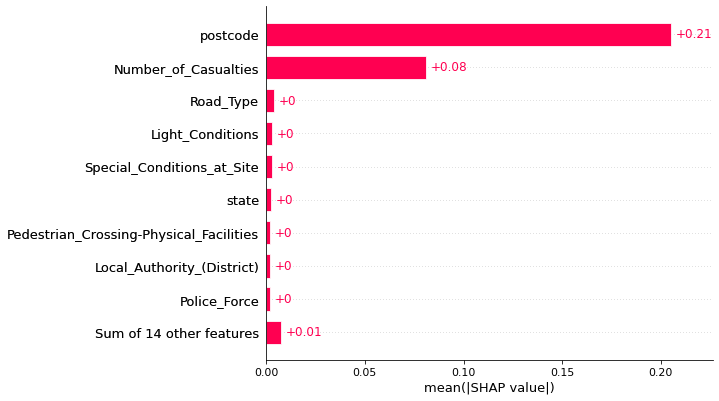

In [52]:
shap.plots.bar(shap_values)

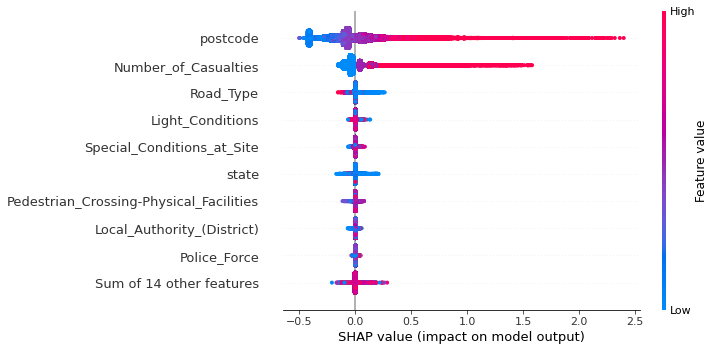

In [53]:
shap.plots.beeswarm(shap_values)